In [1]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(1, parent_dir+'\Covariance and Adjacency Matrix')
from DataManager import dataManager

name: X_test
shape: (640, 31, 1518)
-----------------------
name: X_train
shape: (640, 31, 1395)
-----------------------
name: clip_sizes_test
shape: (2, 129)
-----------------------
name: clip_sizes_train
shape: (2, 127)
-----------------------
name: conv_sizes
shape: (1, 1)
-----------------------
name: n_pre_szr
shape: (1, 1)
-----------------------
name: sel_win_nums_test
shape: (1, 1518)
-----------------------
name: sel_win_nums_train
shape: (1, 1395)
-----------------------
name: soz_ch_ids
shape: (5, 1)
-----------------------
name: stride_sec
shape: (1, 1)
-----------------------
name: window_size_sec
shape: (1, 1)
-----------------------
name: y_test
shape: (1, 1518)
-----------------------
name: y_train
shape: (1, 1395)
-----------------------


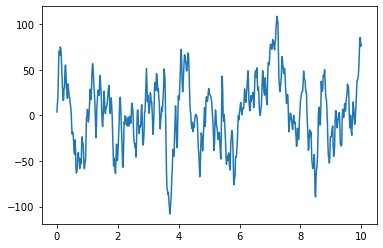

In [2]:
import h5py
import numpy as np
filepath = parent_dir+'\datasets\sample_patients\pat_FR_620.mat'
variables = {}
f = h5py.File(filepath, 'r')
for k, v in f.items():
    variables[k] = np.array(v)
for key in variables.keys():
    print("name:", key)
    print("shape:", variables[key].shape)
    print("-----------------------")
#print sample EGG signal from one node
import matplotlib.pyplot as plt

plt.figure()
ax = plt.axes()
X_train = variables["X_train"]
X_test = variables["X_test"]

ax.plot(np.linspace(0, 10, 640), X_train[:,5,0])

In [3]:
dm = dataManager(variables["X_train"],variables["X_test"],variables["y_train"],variables["y_test"],10**(-4))
#dm.normalize()
#dm.sanity_check(4.514*10**-1, -10**-3, parent_dir)

--------data manager successfully initialized--------


## create normalized adjacency matrix 


In [4]:
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power
def show_heat_map(m):
    plt.imshow(m, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()
    
    
def create_DAD(adj):
    np.fill_diagonal(adj, 1)
    rowsum = np.sum(adj, axis=1)
    d = np.diag_indices(adj.shape[0]) 
    D = np.zeros(adj.shape)
    D[d] = rowsum
    #print(rowsum)
    D = fractional_matrix_power(D, -0.5)
    #print(D)
    return D@adj@D

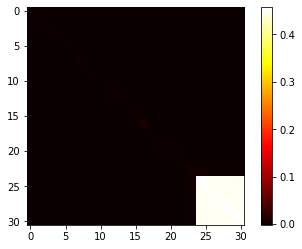

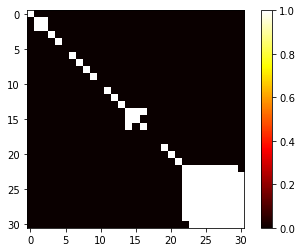

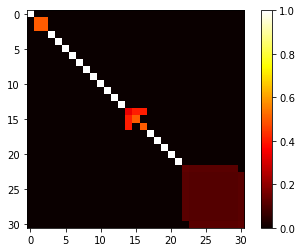

In [5]:
show_heat_map(dm.P_avg_train)
#create DAD from dm
n = 1*10**-3
dm.re_threshold(n)
show_heat_map(dm.A_train)
show_heat_map(create_DAD(dm.A_train))
Araw = dm.A_train

## Modified GDE Class

In [6]:
# solvers.

"""
General Runge-Kutta Solver.
https://en.wikipedia.org/wiki/Runge–Kutta_methods

b_tableau, nested tuple, contains weights of integration. 
f, function, is the function to iterate. Should only be a function of x, t. 
x0, torch.Tensor, is the intial condition.
t0, torch.Tensor, is the start time of integration.
t1, torch.Tensor, is the end time of integration.
N, int, is the desired number of timesteps.

returns x, torch.Tensor, estimated solution of dy/dx = f(x,t) at time t1. 
"""

def explicit_RK(b_tableau, f, x0, t0, t1, N):        
    h = (t1 - t0) / float(N) # calculate step size
    x = x0 # initialize saved dynamics
    mesh = (t0 + h * i for i in range(N)) # generator of time values
    for time in mesh:
        
        k = [f(x, time + h*b_tableau[0][0])] # Covers the first row of the Butcher tableau. 
        for i, row in enumerate(b_tableau[1:-1]): # Covers the middle rows of the Butcher tableau.
            k.append(f(x + sum(w * k[idx] * h for idx, w in enumerate(row[1:])), time + row[0] * h)) # calculate k's. 
        x = x + sum(w * k_i * h for k_i, w in zip(k, b_tableau[-1])) # calculate timestep 
    return x

'''
map everything out:
'y' here is H(t) = H(t-1) + (DAD dot H(t-1) dot W)
'''
RK4 = ((  0,),
       (1/2, 1/2,),
       (1/2,   0,  1/2,),
       (  1,   0,    0,   1,),
       (1/6, 1/3, 1/3, 1/6,))

EF = ((0,),
      (1,))

In [8]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd.functional import vjp
import time

In [47]:
#ODE Part and Adjoint Method

# Convenience tuple -> tensor function
def flatten(*args):
    return(torch.cat(tuple(torch.flatten(arg) for arg in args), dim=0).view(1,-1))

# Convenience tensor -> tuple function
def unflatten(x, n_e, sizes):
    return (x[0, 0:n_e[0]].view(sizes[0]),
            x[0, n_e[0]:n_e[0] + n_e[1]].view(sizes[1]),
            x[0, (n_e[0] + n_e[1]):(n_e[0] + n_e[1] + n_e[2])].view(sizes[2]),
            x[0, (n_e[0] + n_e[1] + n_e[2]):].view(sizes[3]),
            )

class Integrate(torch.autograd.Function):
    def __deepcopy__(self, memo):
        return Integrate(copy.deepcopy(memo))
    
    @staticmethod
    def forward(ctx, Integrator, f, x0, t0, t1, N, net_params, A):
                
        solution = Integrator(EF, lambda x, t: f(x, t, net_params, A), x0, t0, t1, N)
            
        # Save for jacobian calculations in backward()
        ctx.save_for_backward(x0,t0,t1,net_params,A)
        ctx.solution = solution
        ctx.Integrator = Integrator
        ctx.N = N
        ctx.f = f
        
        return solution
    
    @staticmethod
    def backward(ctx, dL_dz1):
        # Get all saved context
        z0, t0, t1, net_params,A = ctx.saved_tensors
        z1 = ctx.solution
        N = ctx.N
        f = ctx.f
        
        print("dL_dz1", dL_dz1.size())
        print("net_params", net_params.size())
        
        
        s0 = [z1, dL_dz1 ,torch.zeros(net_params.size(), dtype=torch.float32)]
        print("s0", s0.size())
        
        def aug_dynamics(s, t, theta, A):
            zt = s[0]
            at = s[1]
            
            
            with torch.enable_grad(): 
                gradients = [vjp(f, 
                                 (s[0][i].unsqueeze(0), t, theta), 
                                  v=-s[1][i].unsqueeze(0),
                                 )[1] for i in range(batch_size)]
                
            return flatten(f(s[0],t,theta),
                    torch.cat([gradient[0] for gradient in gradients], dim=0), 
                    torch.cat([gradient[2].unsqueeze(0) for gradient in gradients], dim=0), 
                    torch.cat([gradient[1].reshape(1,1) for gradient in gradients], dim=0),
                   )#.unsqueeze(2)
        
        '''
        # Convenience sizes
        batch_size = z0.size()[0]
        img_len = int(z0.numel() / batch_size)

        # Compute derivative w.r.t. to end time of integration
        dL_dt1 = dL_dz1.view(batch_size,1,-1).bmm(f(z1, t1, net_params).view(batch_size,-1,1))  # Derivative of loss w.r.t t1
        
        #print("dL_dt1", dL_dt1)
        
        # Initial Condition
        num_elements = (z1.numel(), dL_dz1.numel(), batch_size * net_params.numel(), dL_dt1.numel())
        sizes = (z1.size(), dL_dz1.size(), (batch_size, net_params.numel()), dL_dt1.size())
        s0 = flatten(z1, dL_dz1, torch.zeros((batch_size, net_params.numel()), dtype=torch.float32), -dL_dt1) # initial augmented state
        
        # augmented dynamics function
        def aug_dynamics(s, t, theta):
            s = unflatten(s, num_elements, sizes)
            
            with torch.enable_grad(): 
                gradients = [vjp(f, 
                                 (s[0][i].unsqueeze(0), t, theta), 
                                  v=-s[1][i].unsqueeze(0),
                                 )[1] for i in range(batch_size)]
                
            return flatten(f(s[0],t,theta),
                    torch.cat([gradient[0] for gradient in gradients], dim=0), 
                    torch.cat([gradient[2].unsqueeze(0) for gradient in gradients], dim=0), 
                    torch.cat([gradient[1].reshape(1,1) for gradient in gradients], dim=0),
                   )#.unsqueeze(2)

        # Integrate backwards
        with torch.enable_grad():
            s = ctx.Integrator(EF, lambda x, t: aug_dynamics(x, t, net_params), s0, t1, t0, N)
        
        # Extract derivatives
        _, dL_dz0, dL_dtheta, dL_dt0 = unflatten(s, num_elements, sizes)
        
        # must return something for every input to forward, None for non-tensors
        return None, None, dL_dz0, dL_dt0, dL_dt1, None, dL_dtheta 
        '''
        return None, None, None, None, None, None, net_params, None

In [29]:
class GDE(nn.Module):
    def __init__(self, in_features, out_features):
        super(GDE, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
    
    # H, feature matrix
    # A, precomputed adj matrix
    def forward(self, H, t, weight, A): #x, t, net_params, A
        n = torch.matmul(A, torch.matmul(H, weight))
        return F.relu(n)

class SimularityMatrix(nn.Module):
    def __init__(self, in_features):
        super(SimularityMatrix, self).__init__()
        self.in_features = in_features
        self.weight = nn.Parameter(torch.Tensor(in_features))
        self.reset_parameters()

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) +')'
    
    def reset_parameters(self):
        stdv = 1. / self.weight.size(0) ** 1/2
        self.weight.data.uniform_(-stdv, stdv)
    
    #computes the simularity matrix:
    # H, feature matrix --> N x D
    # A, precomputed adj matrix --> NxN
    # this method is pretty wack, need to find a vectorized way to do it.
    def forward(self, H, H0):
        #get hidden state (concate H0 and H)
        Z = torch.cat((H0, H), 2)
        M = Z.shape[0]
        N = Z.shape[1]
        D = Z.shape[2]
        #centering normalize Z
        Z = self.fcn(Z)
        return self.get_sim_vectorized(Z)
        
    #simularity between node u and node v (shape Mx1xD)
    #return the u,v index of the simularity matrix
    def get_sim(self, u,v):
        theta = torch.diag(self.weight)
        #print(self.weight)
        #print(u.shape, theta.shape, self.weight.shape, torch.transpose(v, 1, 2).shape)
        return torch.squeeze(torch.matmul(torch.matmul(u, theta), torch.transpose(v, 1, 2)))
        
    def get_sim_vectorized(self, Z): # Z is M x N Sx 2D
        theta = torch.diag(self.weight)
        sim_matrix = torch.matmul(torch.matmul(Z, theta), torch.transpose(Z, 1, 2))
        return sim_matrix
        
    #centering-normalizing (CN) operator
    def fcn(self, Z):
        norm_Z = (Z - torch.mean(Z, dim=2, keepdim=True))
        return norm_Z/torch.std(Z, unbiased=True, dim=2, keepdim=True)

In [30]:
# n-layer GCN Network
'''
solver_params = {
    "t0": 0,
    "t1": 1,
    "N": 5,
}
'''
class Net(nn.Module):
    def __init__(self, body_features, solver, solver_params):
        super(Net, self).__init__()
        
        self.f = GDE(body_features,body_features)
        #body
        self.int_f = solver
        self.Integrate = Integrate
        self.solver_params = solver_params
        self.N = solver_params["N"]
        self.h = (solver_params["t1"] - solver_params["t0"]) / solver_params["N"]
        self.t0 = torch.tensor(float(solver_params["t0"]), requires_grad=True)
        self.t1 = torch.tensor(float(solver_params["t1"]), requires_grad=True)
        
        self.net_params = torch.nn.parameter.Parameter(torch.Tensor(body_features, body_features).normal_(mean=0, std=0.1,generator=None), requires_grad=True)
            
        #tail
        self.tail = SimularityMatrix(body_features*2) # size(H_0 + h_u)

    def forward(self, h_0, A):
        #body
        x = self.Integrate.apply(self.int_f, self.f, h_0, self.t0, self.t1, self.N, self.net_params, A)
        
        #tail
        sim_matrix = self.tail(x, h_0)
        return sim_matrix

In [31]:
class sim_loss(torch.nn.Module):

    def __init__(self):
        super(sim_loss,self).__init__()

    def forward(self, sim_matrix, A, epsilon = 1e-8):
        A_tf = (A!=0)
        M = sim_matrix.shape[0]
        abs_N = torch.sum(A_tf, dim = 1, keepdim = True) # Nx1 matrix
        
        logexp_S = torch.log(torch.sum(torch.exp(sim_matrix), dim = 2, keepdim = True))
        
        
        obj_vector = (torch.sum(A_tf*sim_matrix, dim = 2, keepdim = True) - abs_N * logexp_S)
        return -(1/M)*torch.sum(obj_vector)

In [32]:
#save & load checkpoint
import shutil
from torchsummary import summary
from tqdm import tqdm
def save_ckp(state, f_path):
    torch.save(state, f_path)
    print("model saved")
    
def load_ckp(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    return checkpoint

# takes in numpy arrays
def train_GCN(A, X_train, X_test, checkpoint, load = False, print_summary = True):
    #preprocess inputs
    A = torch.from_numpy(A).float()
    X_train = torch.from_numpy(X_train).float()
    X_test = torch.from_numpy(X_test).float()
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    parameters = checkpoint['parameters']
    cumepoch = 0
    A = A.to(device)
    input_features = X_train.to(device)
    valid_features = X_test.to(device)
    
    #initialize model
    model = Net(parameters['body'], parameters['solver'], parameters['solver_params']).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=parameters['learning_rate'], weight_decay=parameters['weight_decay'])
    criterion = sim_loss()
    
    #load past checkpoint if any
    if load:
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        cumepoch = checkpoint['cumepoch']
    
    #print some model info
    if print_summary:
        print(model)
        summary(model, [(31,640), (31,31)])
    
    n_epochs = parameters['num_epochs']
    batch_size = parameters['batch_size']

    model.train()
    for epoch in range(1, n_epochs+1):

        permutation = torch.randperm(input_features.shape[0])

        for i in tqdm(range(0,input_features.shape[0], batch_size)):
            model.train()
            optimizer.zero_grad()

            indices = permutation[i:i+batch_size] if i+batch_size < input_features.shape[0] else permutation[i:] 
            batch_x= input_features[indices, :,:]
            batch_v= valid_features[indices, :,:]

            sim_matrix = model(batch_x, A).to(device)
            train_loss = criterion(sim_matrix, A)
            train_loss.backward()
            optimizer.step()
            
            model.eval()
            sim_matrix_valid = model(batch_v, A).to(device)
            valid_loss = criterion(sim_matrix_valid, A)
            
            print("Epoch:", epoch + cumepoch, "  Batch:", int((i/batch_size)+1),"of size",batch_size, "  Train loss:", float(train_loss), "  Valid loss:",float(valid_loss), end="\r")
        print()
    
    checkpoint = {
        'parameters': parameters,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'cumepoch': n_epochs + cumepoch
    }
    
    return model, checkpoint

In [45]:
#create new model
A = create_DAD(Araw)
X_train = dm.X_train
X_test = dm.X_test
parameters = {
    'body': dm.X_train.shape[2],
    'solver': explicit_RK,
    'solver_params': {
    "t0": 0,
    "t1": 1,
    "N": 5
     },
    'M': dm.X_train.shape[0],
    'batch_size': 128,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
print(parameters)
checkpoint = {'parameters': parameters}

{'body': 640, 'solver': <function explicit_RK at 0x000001E0803381F0>, 'solver_params': {'t0': 0, 't1': 1, 'N': 5}, 'M': 1387, 'batch_size': 128, 'num_epochs': 1, 'learning_rate': 0.001, 'weight_decay': 0.005}


In [49]:
model, checkpoint = train_GCN(A, X_train, X_test, checkpoint, load = False, print_summary = True)

  0%|          | 0/11 [00:00<?, ?it/s]

Net(
  (f): GDE()
  (tail): SimularityMatrix (1280)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               GDE-1              [-1, 31, 640]               0
               GDE-2              [-1, 31, 640]               0
               GDE-3              [-1, 31, 640]               0
               GDE-4              [-1, 31, 640]               0
               GDE-5              [-1, 31, 640]               0
  SimularityMatrix-6               [-1, 31, 31]           1,280
Total params: 1,280
Trainable params: 1,280
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 72.73
Forward/backward pass size (MB): 0.76
Params size (MB): 0.00
Estimated Total Size (MB): 73.50
----------------------------------------------------------------
dL_dt1 torch.Size([128, 31, 640])
net_params torch.Size([640, 640])
s0 torch.Size([640, 640])


RuntimeError: function IntegrateBackward returned an incorrect number of gradients (expected 8, got 1)